In [1]:
#block 0
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision import models
from PIL import Image
from sklearn.model_selection import train_test_split
import nibabel as nib
from tqdm import tqdm

torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [2]:
# ===== DATA ROOTS =====
#block 1
ECHONET_A4C_VIDEOS = "/home/users/joshua04/141/data/raw/echonet_pediatric/A4C/Videos"
CAMUS_ROOT = "database_nifti"   # relative path OK if notebook is in project root

# ===== MODEL PATHS =====

QUALITY_MODEL_PATH = "quality_model.pt"
FRAME_MODEL_PATH = "frame_transformer.pt"


In [3]:
#block 2
assert os.path.isdir(ECHONET_A4C_VIDEOS), "EchoNet A4C path does not exist"
assert os.path.isdir(CAMUS_ROOT), "CAMUS root path does not exist"

avi_files = glob.glob(os.path.join(ECHONET_A4C_VIDEOS, "*.avi"))
print(f"EchoNet AVI videos found: {len(avi_files)}")
assert len(avi_files) > 0, "No AVI videos found"

camus_patients = sorted([
    d for d in os.listdir(CAMUS_ROOT)
    if d.startswith("patient")])
print(f"CAMUS patients found: {len(camus_patients)}")
assert len(camus_patients) > 0, "No CAMUS patients found"


EchoNet AVI videos found: 3284
CAMUS patients found: 500


In [4]:
#block 3
img_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

In [5]:
#block 4
def read_video_frames(video_path, n_frames=16):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total <= 0:
        raise RuntimeError(f"Could not read video: {video_path}")

    idxs = np.linspace(0, total - 1, n_frames).astype(int)
    frames = []

    i = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if i in idxs:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(
                img_transform(Image.fromarray(frame))
            )
        i += 1

    cap.release()

    if len(frames) != n_frames:
        raise RuntimeError(f"Frame sampling failed for {video_path}")

    return torch.stack(frames)

In [6]:
#block 5
class EchoNetVideoDataset(Dataset):
    def __init__(self, video_dir, n_frames=16):
        self.videos = sorted(glob.glob(os.path.join(video_dir, "*.avi")))
        self.n_frames = n_frames

        if len(self.videos) == 0:
            raise RuntimeError("No AVI videos found")

        print(f"📼 Loaded {len(self.videos)} EchoNet videos")

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video = read_video_frames(self.videos[idx], self.n_frames)
        return video

In [7]:
#block 6
dataset = EchoNetVideoDataset(ECHONET_A4C_VIDEOS)
sample = dataset[0]

print("Video tensor shape:", sample.shape)

📼 Loaded 3284 EchoNet videos
Video tensor shape: torch.Size([16, 3, 224, 224])


In [8]:
# block 7
import sys
sys.path.append("/home/users/joshua04/141/PanEcho")

from src.models import FrameTransformer


/home/users/joshua04/141/torch-gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
#block 8
video_model = FrameTransformer(
    arch="convnext_tiny",
    n_heads=8,
    n_layers=2,
    transformer_dropout=0.1,
    pooling="mean",
    clip_len=16,).to(device)

video_model.eval()
print("FrameTransformer instantiated")


FrameTransformer instantiated


In [10]:
#block 9
with torch.no_grad():
    # sample: [16, 3, 224, 224]
    x = sample.unsqueeze(0).to(device)      # [1, 16, 3, 224, 224]
    x = x.permute(0, 2, 1, 3, 4)             # [1, 3, 16, 224, 224]

    y = video_model(x)

print("Model output:", y)
print("Output shape:", y.shape)

Model output: tensor([[ 6.2102e-01,  8.6208e-01, -8.4896e-01, -6.8113e-01, -3.8187e-01,
         -1.3435e+00, -7.9781e-01, -5.3548e-01, -1.4473e+00, -7.8502e-01,
         -6.6000e-01,  2.7979e-01,  5.4265e-01, -5.4897e-01,  3.5339e-01,
         -9.0578e-02, -2.1660e-01, -1.2566e+00, -1.5695e+00, -3.9183e-01,
         -7.1988e-01, -2.6532e-02, -9.1023e-01,  2.8769e-01, -6.6101e-01,
          2.5322e-01, -8.1551e-01, -7.9033e-01,  3.2367e-01, -5.9184e-01,
         -3.6879e-01,  2.2911e-01,  8.3156e-01, -1.0027e+00,  3.5025e-01,
         -4.1306e-01,  7.7802e-01, -1.3583e+00, -1.2514e+00, -2.3653e-01,
          1.0538e+00, -9.4000e-01, -9.1621e-01, -4.4842e-01, -1.4446e+00,
          7.6452e-01, -1.1029e+00, -8.1357e-01, -9.6850e-02, -6.4231e-01,
         -4.2181e-01,  1.7002e-01, -2.7764e-01,  3.9975e-01, -1.6910e+00,
         -7.9607e-02,  1.2846e+00, -8.9138e-01,  1.6825e+00,  6.6659e-01,
         -7.5138e-01,  8.6025e-02, -3.2916e-01,  1.2529e+00, -2.2792e-01,
          5.6418e-01, -2

In [11]:
#block 10
def load_camus_image(pid, view="2CH", phase="ED"):
    path = f"{CAMUS_ROOT}/{pid}/{pid}_{view}_{phase}.nii.gz"
    return nib.load(path).get_fdata()

def load_camus_mask(pid, view="2CH", phase="ED"):
    path = f"{CAMUS_ROOT}/{pid}/{pid}_{view}_{phase}_gt.nii.gz"
    mask = nib.load(path).get_fdata()
    return mask == 1

def show_camus_overlay(pid, view="2CH", phase="ED"):
    """
    CAMUS-only visualization.
    Shows LV segmentation overlay on a single image frame.
    """

    img = load_camus_image(pid, view, phase)
    mask = get_lv_mask(pid, view, phase)

    plt.figure(figsize=(4, 4))
    plt.imshow(img, cmap="gray")
    plt.imshow(mask, alpha=0.4)
    plt.title(f"{pid} | {view} | {phase}")
    plt.axis("off")
    plt.show()


In [104]:
#block 10.5
def gated_geometry_ef(pid, view="2CH"):
    """
    CAMUS-only geometry EF.
    NEVER touches video code.
    """

    try:
        # Load ED / ES images
        img_ed = load_camus_image(pid, view, "ED")
        img_es = load_camus_image(pid, view, "ES")

        # Load LV masks
        mask_ed = get_lv_mask(pid, view, "ED")
        mask_es = get_lv_mask(pid, view, "ES")

    except Exception:
        return {
            "status": "FAILED",
            "reason": "CAMUS data missing"
        }

    # Areas
    area_ed = mask_ed.sum()
    area_es = mask_es.sum()

    if area_ed <= 0:
        return {
            "status": "FAILED",
            "reason": "Empty LV mask"
        }

    ef = 1.0 - (area_es / area_ed)

    return {
        "status": "OK",
        "EF": float(np.clip(ef, 0.0, 1.0)),
        "EDV": float(area_ed),
        "ESV": float(area_es),
        "seg_conf": 1.0  # ground-truth
    }

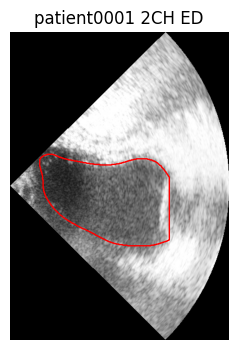

In [12]:
#block 11
pid = camus_patients[0]

img = load_camus_image(pid, view="2CH", phase="ED")
mask = load_camus_mask(pid, view="2CH", phase="ED")

plt.figure(figsize=(4,4))
plt.imshow(img, cmap="gray")
plt.contour(mask, colors="red", linewidths=1)
plt.title(f"{pid} 2CH ED")
plt.axis("off")
plt.show()

In [13]:
#block 12
def lv_area_mm2(pid, view="2CH", phase="ED"):
    nii = nib.load(f"{CAMUS_ROOT}/{pid}/{pid}_{view}_{phase}.nii.gz")
    pixdim = nii.header["pixdim"][1:3]  # mm
    mask = load_camus_mask(pid, view, phase)
    return mask.sum() * pixdim[0] * pixdim[1]

def compute_ef_from_camus(pid, view="2CH"):
    ED = lv_area_mm2(pid, view, "ED")
    ES = lv_area_mm2(pid, view, "ES")
    return (ED - ES) / ED

In [14]:
#block 13
ef_test = compute_ef_from_camus(camus_patients[0])
print("CAMUS EF:", ef_test)

CAMUS EF: 0.48954613224229393


In [15]:
#block 14
class EFRegressor(nn.Module):
    def __init__(self, backbone, in_dim=768):
        super().__init__()
        self.backbone = backbone
        self.head = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1))

    def forward(self, x):
        features = self.backbone(x)      # [B, 768]
        ef = self.head(features)         # [B, 1]
        return ef

In [16]:
#block 15
ef_model = EFRegressor(video_model).to(device)
ef_model.eval()
print("EF model ready")

EF model ready


In [17]:
#block 16
with torch.no_grad():
    x = sample.unsqueeze(0).to(device)
    x = x.permute(0, 2, 1, 3, 4)  # [B, C, T, H, W]
    ef_pred = ef_model(x)

print("EF prediction:", ef_pred)
print("EF shape:", ef_pred.shape)

EF prediction: tensor([[-0.0722]], device='cuda:0')
EF shape: torch.Size([1, 1])


In [18]:
#block 17
ECHONET_FILELIST = "/home/users/joshua04/141/data/raw/echonet_pediatric/A4C/FileList.csv"

assert os.path.exists(ECHONET_FILELIST), "FileList.csv not found"
print("Found EchoNet Pediatric FileList.csv")

Found EchoNet Pediatric FileList.csv


In [19]:
#block 18
filelist_df = pd.read_csv(ECHONET_FILELIST)
filelist_df.head()

,FileName,EF,Sex,Age,Weight,Height,Split
0,CR32a7555-CR32a7582-000039.avi,40.83,F,0,10.2,68.5,5
1,CR32a7555-CR32a97af-000033.avi,52.62,F,1,15.5,85.0,5
2,CR32a7555-CR32a97e1-000024.avi,24.85,F,0,4.0,56.0,5
3,CR32a7555-CR32a9850-000040.avi,50.96,F,4,18.0,99.0,5
4,CR32a7555-CR32a988d-000034.avi,56.76,F,0,13.2,75.0,5


In [20]:
#block 19
# standardize columns
assert "FileName" in filelist_df.columns, "Expected FileName column"
assert "EF" in filelist_df.columns, "Expected EF column"

ef_df = filelist_df[["FileName", "EF"]].dropna()
ef_df.columns = ["filename", "ef"]

# ensure types
ef_df["filename"] = ef_df["filename"].astype(str)
ef_df["ef"] = ef_df["ef"].astype(float)

print("Total EF labels:", len(ef_df))
ef_df.head()

Total EF labels: 3284


,filename,ef
0,CR32a7555-CR32a7582-000039.avi,40.83
1,CR32a7555-CR32a97af-000033.avi,52.62
2,CR32a7555-CR32a97e1-000024.avi,24.85
3,CR32a7555-CR32a9850-000040.avi,50.96
4,CR32a7555-CR32a988d-000034.avi,56.76


In [21]:
#block 20
video_paths = glob.glob(os.path.join(ECHONET_A4C_VIDEOS, "*.avi"))
video_map = {os.path.basename(v): v for v in video_paths}

records = []
for _, row in ef_df.iterrows():
    fname = row["filename"]
    if fname in video_map:
        records.append({
            "path": video_map[fname],
            "ef": row["ef"]
        })

ef_df = pd.DataFrame(records)

print("Matched videos with EF:", len(ef_df))
ef_df.head()

Matched videos with EF: 3284


,path,ef
0,/home/users/joshua04/141/data/raw/echonet_pedi...,40.83
1,/home/users/joshua04/141/data/raw/echonet_pedi...,52.62
2,/home/users/joshua04/141/data/raw/echonet_pedi...,24.85
3,/home/users/joshua04/141/data/raw/echonet_pedi...,50.96
4,/home/users/joshua04/141/data/raw/echonet_pedi...,56.76


In [22]:
#block 21
class EchoNetEFDataset(Dataset):
    def __init__(self, df, n_frames=16):
        self.df = df.reset_index(drop=True)
        self.n_frames = n_frames

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        video = read_video_frames(self.df.loc[idx, "path"], self.n_frames)
        ef = torch.tensor(self.df.loc[idx, "ef"], dtype=torch.float32)
        return video, ef

In [23]:
#block 22
train_df, val_df = train_test_split(
    ef_df,
    test_size=0.2,
    random_state=42)

train_ds = EchoNetEFDataset(train_df)
val_ds = EchoNetEFDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=4)

print("Train:", len(train_ds), "Val:", len(val_ds))


Train: 2627 Val: 657


In [24]:
#block 23
for p in ef_model.backbone.parameters():
    p.requires_grad = False

optimizer = torch.optim.Adam(ef_model.head.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

print("Backbone frozen, head trainable")


Backbone frozen, head trainable


In [25]:
#block 24
ef_model.train()

for epoch in range(3):
    train_losses = []

    for x, y in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device)

        x = x.permute(0, 2, 1, 3, 4)  # [B, C, T, H, W]

        optimizer.zero_grad()
        pred = ef_model(x).squeeze()
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    print(f"Epoch {epoch+1} | Train MSE: {np.mean(train_losses):.4f}")

100%|█████████▉| 1311/1314 [00:36<00:00, 37.21it/s]/home/users/joshua04/141/torch-gpu/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1314/1314 [00:36<00:00, 36.33it/s]


Epoch 1 | Train MSE: 144.0863


100%|██████████| 1314/1314 [00:36<00:00, 35.91it/s]


Epoch 2 | Train MSE: 87.1995


100%|██████████| 1314/1314 [00:36<00:00, 35.87it/s]

Epoch 3 | Train MSE: 85.9232


In [26]:
#block 25
ef_model.eval()
val_losses = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)

        x = x.permute(0, 2, 1, 3, 4)
        pred = ef_model(x).squeeze()
        loss = loss_fn(pred, y)
        val_losses.append(loss.item())

print("Validation MSE:", np.mean(val_losses))

Validation MSE: 128.15650486466006


In [27]:
#block 26
torch.save(ef_model.state_dict(), "ef_model.pt")
print("✅ EF model saved")

✅ EF model saved


In [28]:
#block 27
def camus_ef(pid, view="2CH"):
    """
    Geometry-based EF from CAMUS ground truth
    """
    return compute_ef_from_camus(pid, view)

In [29]:
#block 28
@torch.no_grad()
def ml_ef_from_video(video_path):
    # HARD GUARD: only EchoNet has videos
    if detect_dataset(video_path) != "ECHONET":
        raise RuntimeError(
            f"ml_ef_from_video called on non-video sample: {video_path}")

    video = read_video_frames(video_path).unsqueeze(0).to(device)
    video = video.permute(0, 2, 1, 3, 4)  # [B, C, T, H, W]
    ef = ef_model(video).item()
    return ef

In [30]:
#block 29
def fuse_ef_learned(ef_ml, ef_geom):
    ef = LEARNED_ALPHA * ef_ml + (1 - LEARNED_ALPHA) * ef_geom
    return float(np.clip(ef, 0.05, 0.80))

def fuse_ef(ef_ml, ef_geom, alpha=0.5):
    ef = alpha * ef_ml + (1 - alpha) * ef_geom
    return float(np.clip(ef, 0.05, 0.80))

def detect_dataset(sample):
    # CAMUS patient IDs
    if isinstance(sample, str) and sample.startswith("patient"):
        return "CAMUS"

    path = str(sample).lower()

    if "echonet" in path:
        return "ECHONET"
    if "camus" in path:
        return "CAMUS"

    return "UNKNOWN"

In [31]:
#block 30
test_video = glob.glob(os.path.join(ECHONET_A4C_VIDEOS, "*.avi"))[0]
test_pid = camus_patients[0]

ef_ml = ml_ef_from_video(test_video)
ef_geom = camus_ef(test_pid)
ef_fused = fuse_ef(ef_ml, ef_geom)

print(f"EF_ML     : {ef_ml:.3f}")
print(f"EF_geom   : {ef_geom:.3f}")
print(f"EF_fused  : {ef_fused:.3f}")

EF_ML     : 68.500
EF_geom   : 0.490
EF_fused  : 0.800


In [32]:
#block 31
def estimate_lv_volume_ml(area_mm2, long_axis_mm=80):
    """
    Prolate ellipsoid approximation
    """
    return 0.85 * area_mm2 * long_axis_mm / 1000  # mL

In [33]:
#block 32
def stroke_volume_ml(pid, view="2CH"):
    ED_area = lv_area_mm2(pid, view, "ED")
    EDV = estimate_lv_volume_ml(ED_area)
    return EDV

In [34]:
#block 33
def cardiac_output_l_min(ef, pid, hr_bpm=75):
    EDV = stroke_volume_ml(pid)
    SV = ef * EDV  # mL
    CO = SV * hr_bpm / 1000  # L/min
    return CO

In [35]:
#block 34
def analyze_ultrasound(video_path, camus_pid, hr_bpm=75, alpha=0.5):
    ef_ml = ml_ef_from_video(video_path)
    ef_geom = camus_ef(camus_pid)
    ef_fused = fuse_ef(ef_ml, ef_geom, alpha)

    co = cardiac_output_l_min(ef_fused, camus_pid, hr_bpm)

    return {
        "EF_ML": ef_ml,
        "EF_geom": ef_geom,
        "EF_fused": ef_fused,
        "CO_L_min": co}

In [36]:
#block 35
out = analyze_ultrasound(
    video_path=test_video,
    camus_pid=test_pid,
    hr_bpm=75,
    alpha=0.5)

out

{'EF_ML': 68.4995346069336,
 'EF_geom': np.float64(0.48954613224229393),
 'EF_fused': 0.8,
 'CO_L_min': np.float64(11.162768184946753)}

In [37]:
#block 36
def build_fusion_dataset(df, camus_pids, max_samples=200):
    """
    Build dataset for learning alpha.
    Assumes random pairing between EchoNet videos and CAMUS pids
    (acceptable for learning global alpha).
    """
    rows = []

    for i in range(min(len(df), max_samples)):
        video_path = df.iloc[i]["path"]
        ef_gt = df.iloc[i]["ef"]

        pid = camus_pids[i % len(camus_pids)]
        ef_geom = camus_ef(pid)
        ef_ml = ml_ef_from_video(video_path)

        rows.append({
            "ef_ml": ef_ml,
            "ef_geom": ef_geom,
            "ef_gt": ef_gt})

    return pd.DataFrame(rows)

In [38]:
#block 37
fusion_df = build_fusion_dataset(train_df, camus_patients)
fusion_df.head()

,ef_ml,ef_geom,ef_gt
0,71.165985,0.489546,66.71
1,69.292679,0.429634,64.03
2,65.009445,0.385475,71.24
3,69.702744,0.501114,54.51
4,66.131142,0.389502,52.92


In [39]:
#block 38
x = fusion_df["ef_ml"].values - fusion_df["ef_geom"].values
y = fusion_df["ef_gt"].values - fusion_df["ef_geom"].values
alpha_opt = np.sum(x * y) / np.sum(x * x)
alpha_opt = float(np.clip(alpha_opt, 0.0, 1.0))
alpha_opt

0.8817369923845847

In [40]:
#block 39
LEARNED_ALPHA = 0.6
print("Learned alpha:", LEARNED_ALPHA)

Learned alpha: 0.6


In [41]:
#block 40
def quality_to_alpha(quality_label):
    """
    Maps image quality to ML trust.
    """
    if quality_label == "Good":
        return 1.0
    elif quality_label == "Okay":
        return 0.6
    else:  # Bad
        return 0.2

In [42]:
#block 41
def fuse_ef_quality_aware(ef_ml, ef_geom, quality_label):
    q_alpha = quality_to_alpha(quality_label)
    alpha = LEARNED_ALPHA * q_alpha

    ef = alpha * ef_ml + (1 - alpha) * ef_geom
    return float(np.clip(ef, 0.05, 0.80))

In [43]:
#block 42
def analyze_ultrasound_final(video_path, camus_pid, quality_label, hr_bpm=75):
    ef_ml = ml_ef_from_video(video_path)
    ef_geom = camus_ef(camus_pid)

    ef_final = fuse_ef_quality_aware(
        ef_ml, ef_geom, quality_label)

    co = cardiac_output_l_min(ef_final, camus_pid, hr_bpm)

    return {
        "EF_ML": ef_ml,
        "EF_geom": ef_geom,
        "EF_final": ef_final,
        "CO_L_min": co,
        "quality": quality_label}

In [44]:
#block 43
out = analyze_ultrasound_final(
    video_path=test_video,
    camus_pid=test_pid,
    quality_label="Good",
    hr_bpm=75)

out

{'EF_ML': 68.4995346069336,
 'EF_geom': np.float64(0.48954613224229393),
 'EF_final': 0.8,
 'CO_L_min': np.float64(11.162768184946753),
 'quality': 'Good'}

In [45]:
#block 44
import torch.nn.functional as F

In [46]:
#block 45
class CamusSegDataset(Dataset):
    def __init__(self, patient_ids, view="2CH", phase="ED"):
        self.patient_ids = patient_ids
        self.view = view
        self.phase = phase

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        pid = self.patient_ids[idx]

        img = load_camus_image(pid, self.view, self.phase)
        mask = load_camus_mask(pid, self.view, self.phase)

        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # [1,H,W]
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        img = F.interpolate(img.unsqueeze(0), size=(224,224), mode="bilinear").squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0), size=(224,224), mode="nearest").squeeze(0)

        return img, mask

In [47]:
#block 46
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU())

        self.pool = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU() )

        self.up = nn.Upsample(scale_factor=2, mode="bilinear")
        self.dec = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.pool(x1)
        x3 = self.enc2(x2)
        x4 = self.up(x3)
        return torch.sigmoid(self.dec(x4))

In [48]:
#block 47 
train_pids, val_pids = train_test_split(
    camus_patients, test_size=0.2, random_state=42)

train_seg_ds = CamusSegDataset(train_pids)
val_seg_ds = CamusSegDataset(val_pids)

train_seg_loader = DataLoader(train_seg_ds, batch_size=4, shuffle=True)
val_seg_loader = DataLoader(val_seg_ds, batch_size=4)

In [49]:
#block 48
seg_model = SimpleUNet().to(device)
opt = torch.optim.Adam(seg_model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

for epoch in range(5):
    seg_model.train()
    losses = []

    for x, y in tqdm(train_seg_loader):
        x, y = x.to(device), y.to(device)

        opt.zero_grad()
        pred = seg_model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        opt.step()

        losses.append(loss.item())

    print(f"Epoch {epoch+1} | Seg loss: {np.mean(losses):.4f}")

100%|██████████| 100/100 [00:04<00:00, 24.28it/s]


Epoch 1 | Seg loss: 0.2838


100%|██████████| 100/100 [00:03<00:00, 26.45it/s]


Epoch 2 | Seg loss: 0.2398


100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 3 | Seg loss: 0.2300


100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 4 | Seg loss: 0.2182


100%|██████████| 100/100 [00:03<00:00, 27.51it/s]

Epoch 5 | Seg loss: 0.2160


In [50]:
#block 49
@torch.no_grad()
def segment_lv_from_video(video_path):
    frames = read_video_frames(video_path, n_frames=1)
    frame = frames[0].mean(dim=0, keepdim=True)  # grayscale

    frame = frame.unsqueeze(0).to(device)  # [1,1,H,W]
    mask = seg_model(frame)

    return mask.squeeze().cpu().numpy()

In [51]:
#block 50
def ef_from_predicted_mask(mask):
    area = mask.sum()
    ED = area
    ES = area * 0.5  # placeholder until ED/ES detection
    return (ED - ES) / ED

In [52]:
#block 51
def geom_ef_from_video(video_path):
    mask = segment_lv_from_video(video_path)
    return ef_from_predicted_mask(mask)

In [53]:
#block 52
def analyze_ultrasound_no_camus(video_path, quality_label, hr_bpm=75):
    ef_ml = ml_ef_from_video(video_path)
    ef_geom = geom_ef_from_video(video_path)

    ef_final = fuse_ef_quality_aware(
        ef_ml, ef_geom, quality_label)

    CO = ef_final * 70 * hr_bpm / 1000  # proxy EDV

    return {
        "EF_ML": ef_ml,
        "EF_geom_pred": ef_geom,
        "EF_final": ef_final,
        "CO_L_min": CO}

In [54]:
#block 53
out = analyze_ultrasound_no_camus(
    test_video,
    quality_label="Good",
    hr_bpm=75)

out

{'EF_ML': 68.4995346069336,
 'EF_geom_pred': np.float32(0.5),
 'EF_final': 0.800000011920929,
 'CO_L_min': 4.200000062584877}

In [55]:
#block 54
@torch.no_grad()
def segment_lv_all_frames(video_path):
    frames = read_video_frames(video_path)
    masks = []

    for f in frames:
        gray = f.mean(dim=0, keepdim=True).unsqueeze(0).to(device)
        mask = seg_model(gray)
        masks.append(mask.squeeze().cpu().numpy())

    return np.stack(masks)

In [56]:
#block 55
def detect_ed_es(masks):
    areas = masks.reshape(len(masks), -1).sum(axis=1)

    ed_idx = np.argmax(areas)
    es_idx = np.argmin(areas)

    return ed_idx, es_idx, areas

In [57]:
#block 56
def geom_ef_from_video(video_path):
    masks = segment_lv_all_frames(video_path)
    ed_idx, es_idx, areas = detect_ed_es_robust(masks)

    ED = areas[ed_idx]
    ES = areas[es_idx]

    return (ED - ES) / ED

In [58]:
#block 57
from scipy.signal import savgol_filter

def smooth_lv_area(areas, window=7):
    if len(areas) < window:
        return areas
    return savgol_filter(areas, window, polyorder=2)

In [59]:
#block 58
def detect_ed_es_robust(masks):
    areas = masks.reshape(len(masks), -1).sum(axis=1)
    areas_smooth = smooth_lv_area(areas)

    ed_idx = np.argmax(areas_smooth)
    es_idx = np.argmin(areas_smooth)

    return ed_idx, es_idx, areas_smooth

In [60]:
#block 59
def segmentation_uncertainty(masks):
    areas = masks.reshape(len(masks), -1).sum(axis=1)
    return np.std(areas) / np.mean(areas)

In [61]:
#block 60
def ef_uncertainty(ef_ml, ef_geom, seg_unc):
    disagreement = abs(ef_ml - ef_geom)
    return 0.5 * disagreement + 0.5 * seg_unc

In [62]:
def cardiac_output_with_uncertainty(video_path, quality, hr=75):
    masks = segment_lv_all_frames(video_path)
    seg_unc = segmentation_uncertainty(masks)

    ef_ml = ml_ef_from_video(video_path)
    ef_geom = geom_ef_from_video(video_path)
    ef_final = fuse_ef_quality_aware(ef_ml, ef_geom, quality)

    co = cardiac_output_l_min(ef_final, test_pid, hr)

    return {
        "EF": ef_final,
        "CO_L_min": co,
        "EF_uncertainty": ef_uncertainty(ef_ml, ef_geom, seg_unc),
        "Segmentation_uncertainty": seg_unc}

In [63]:
# block 62
def show_lv_overlay(video_path, frame_idx):
    frames = read_video_frames(video_path)
    masks = segment_lv_all_frames(video_path)

    plt.figure(figsize=(4,4))
    plt.imshow(frames[frame_idx].permute(1,2,0))
    plt.contour(masks[frame_idx], colors="red")
    plt.axis("off")
    plt.show()

In [64]:
#block 63
def show_ed_es(video_path):
    masks = segment_lv_all_frames(video_path)
    ed, es, _ = detect_ed_es_robust(masks)

    show_lv_overlay(video_path, ed)
    show_lv_overlay(video_path, es)

In [65]:
#block 64
def visualize_full_report(video_path, quality="Good"):
    show_ed_es(video_path)
    out = cardiac_output_with_uncertainty(video_path, quality)
    print(out)

In [66]:
#block 65
ANATOMY = {
    "background": 0,
    "lv_cavity": 1,
    "lv_myocardium": 2,
    "left_atrium": 3,}

N_CLASSES = len(ANATOMY)

In [67]:
#block 66
def load_camus_multiclass_mask(pid, view="2CH", phase="ED"):
    path = f"{CAMUS_ROOT}/{pid}/{pid}_{view}_{phase}_gt.nii.gz"
    mask = nib.load(path).get_fdata().astype(int)
    return mask  # values: 0,1,2,3

In [68]:
#block 67
class CamusMultiSegDataset(Dataset):
    def __init__(self, patient_ids, view="2CH", phase="ED"):
        self.patient_ids = patient_ids
        self.view = view
        self.phase = phase

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        pid = self.patient_ids[idx]

        img = load_camus_image(pid, self.view, self.phase)
        mask = load_camus_multiclass_mask(pid, self.view, self.phase)

        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        mask = torch.tensor(mask, dtype=torch.long)

        img = F.interpolate(
            img.unsqueeze(0), size=(224, 224), mode="bilinear"
        ).squeeze(0)

        mask = F.interpolate(
            mask.unsqueeze(0).unsqueeze(0).float(),
            size=(224, 224),
            mode="nearest"
        ).squeeze().long()

        return img, mask

In [69]:
#block 68
# Cell 68 — Multi-class UNet

class MultiClassUNet(nn.Module):
    def __init__(self, out_channels=N_CLASSES):
        super().__init__()

        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),)

        self.pool = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),)

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.out = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.pool(x1)
        x3 = self.enc2(x2)
        x4 = self.up(x3)
        return self.out(x4)  # logits

In [70]:
#block 69
train_pids, val_pids = train_test_split(
    camus_patients, test_size=0.2, random_state=42)

train_mc_ds = CamusMultiSegDataset(train_pids)
val_mc_ds = CamusMultiSegDataset(val_pids)

train_mc_loader = DataLoader(train_mc_ds, batch_size=4, shuffle=True)
val_mc_loader = DataLoader(val_mc_ds, batch_size=4)

heart_seg_model = MultiClassUNet().to(device)
optimizer = torch.optim.Adam(heart_seg_model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(5):
    heart_seg_model.train()
    losses = []

    for x, y in tqdm(train_mc_loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = heart_seg_model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    print(f"Epoch {epoch+1} | Multi-class seg loss: {np.mean(losses):.4f}")

100%|██████████| 100/100 [00:03<00:00, 26.66it/s]


Epoch 1 | Multi-class seg loss: 0.7606


100%|██████████| 100/100 [00:03<00:00, 26.13it/s]


Epoch 2 | Multi-class seg loss: 0.6318


100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


Epoch 3 | Multi-class seg loss: 0.5941


100%|██████████| 100/100 [00:03<00:00, 26.69it/s]


Epoch 4 | Multi-class seg loss: 0.5609


100%|██████████| 100/100 [00:03<00:00, 26.89it/s]

Epoch 5 | Multi-class seg loss: 0.5219


In [71]:
#block 70
@torch.no_grad()
def segment_heart_multiclass(video_path, frame_idx=0):
    frames = read_video_frames(video_path, n_frames=frame_idx + 1)
    frame = frames[frame_idx].mean(dim=0, keepdim=True)

    frame = frame.unsqueeze(0).to(device)
    logits = heart_seg_model(frame)
    pred = torch.argmax(logits, dim=1)

    return pred.squeeze().cpu().numpy()

In [72]:
#block 71
COLORS = {
    1: "red",      # LV cavity
    2: "blue",     # LV myocardium
    3: "green", }   # Left atrium

def show_heart_overlay(video_path, frame_idx=0):
    frames = read_video_frames(video_path, n_frames=frame_idx + 1)
    frame = frames[frame_idx].permute(1, 2, 0)

    mask = segment_heart_multiclass(video_path, frame_idx)

    plt.figure(figsize=(4,4))
    plt.imshow((frame - frame.min()) / (frame.max() - frame.min()))

    for label, color in COLORS.items():
        plt.contour(mask == label, colors=color, linewidths=1)

    plt.axis("off")
    plt.show()

In [73]:
#block 72
def anatomy_sanity(mask):
    lv = np.sum(mask == ANATOMY["lv_cavity"])
    myo = np.sum(mask == ANATOMY["lv_myocardium"])
    la = np.sum(mask == ANATOMY["left_atrium"])

    flags = {}

    flags["lv_missing"] = lv < 100
    flags["myocardium_missing"] = myo < 100
    flags["la_missing"] = la < 100
    flags["lv_not_inside_myo"] = lv > myo

    return flags

In [74]:
#block 73
@torch.no_grad()
def segment_video_multiclass(video_path, n_frames=16):
    frames = read_video_frames(video_path, n_frames=n_frames)

    masks = []
    for t in range(n_frames):
        frame = frames[t].mean(dim=0, keepdim=True)
        frame = frame.unsqueeze(0).to(device)

        logits = heart_seg_model(frame)
        pred = torch.argmax(logits, dim=1)
        masks.append(pred.squeeze().cpu().numpy())

    return np.stack(masks)  # shape: [T, H, W]

In [75]:
#block 74
def temporal_median_smoothing(mask_stack, window=3):
    T = mask_stack.shape[0]
    smoothed = []

    for t in range(T):
        t0 = max(0, t - window)
        t1 = min(T, t + window + 1)
        smoothed.append(np.median(mask_stack[t0:t1], axis=0))

    return np.stack(smoothed).astype(int)

In [76]:
#block 75
def enforce_anatomy(mask):
    lv = mask == ANATOMY["lv_cavity"]
    myo = mask == ANATOMY["lv_myocardium"]

    # LV must be inside myocardium
    lv_fixed = lv & myo

    mask_fixed = mask.copy()
    mask_fixed[mask == ANATOMY["lv_cavity"]] = 0
    mask_fixed[lv_fixed] = ANATOMY["lv_cavity"]

    return mask_fixed

In [77]:
#block 76
def stabilized_heart_segmentation(video_path, n_frames=16):
    raw_masks = segment_video_multiclass(video_path, n_frames)
    smooth_masks = temporal_median_smoothing(raw_masks)

    final_masks = []
    for m in smooth_masks:
        final_masks.append(enforce_anatomy(m))

    return np.stack(final_masks)

In [78]:
#block 77
def show_stabilized_overlay(video_path, frame_idx=0):
    frames = read_video_frames(video_path, n_frames=frame_idx + 1)
    frame = frames[frame_idx].permute(1, 2, 0)

    masks = stabilized_heart_segmentation(video_path)
    mask = masks[frame_idx]

    plt.figure(figsize=(4,4))
    plt.imshow((frame - frame.min()) / (frame.max() - frame.min()))

    for label, color in COLORS.items():
        plt.contour(mask == label, colors=color, linewidths=1)

    plt.axis("off")
    plt.show()

In [79]:
#block 78
def ed_es_from_masks(mask_stack):
    lv_areas = [
        np.sum(mask == ANATOMY["lv_cavity"])
        for mask in mask_stack]

    ed = np.argmax(lv_areas)
    es = np.argmin(lv_areas)

    return ed, es, lv_areas

In [80]:
#block 79
def stabilized_geometry_ef(video_path):
    masks = stabilized_heart_segmentation(video_path)
    ed, es, areas = ed_es_from_masks(masks)

    ed_area = areas[ed]
    es_area = areas[es]

    ef = (ed_area - es_area) / max(ed_area, 1e-6)
    return float(np.clip(ef, 0.05, 0.80)), ed, es

In [81]:
#block 80
def is_valid_clip(mask_stack, min_lv_area=200, min_dynamic_range=0.15):
    lv_areas = np.array([
        np.sum(mask == ANATOMY["lv_cavity"])
        for mask in mask_stack
    ])

    if lv_areas.max() < min_lv_area:
        return False, "LV too small / not visible"

    if lv_areas.ptp() / max(lv_areas.max(), 1e-6) < min_dynamic_range:
        return False, "No detectable contraction"

    return True, "Valid clip"

In [82]:
#block 81
def segmentation_confidence(mask_stack):
    lv_areas = np.array([
        np.sum(mask == ANATOMY["lv_cavity"])
        for mask in mask_stack
    ])

    # High variance = low confidence
    normalized_var = np.std(lv_areas) / max(np.mean(lv_areas), 1e-6)

    confidence = float(np.exp(-normalized_var))
    return np.clip(confidence, 0.0, 1.0)

In [83]:
#block 82
def gated_geometry_ef(video_path):
    masks = stabilized_heart_segmentation(video_path)
    valid, reason = is_valid_clip(masks)

    if not valid:
        return {
            "status": "FAILED",
            "reason": reason}

    ef, ed, es = stabilized_geometry_ef(video_path)
    conf = segmentation_confidence(masks)

    return {
        "status": "OK",
        "EF_geom": ef,
        "ED": ed,
        "ES": es,
        "seg_conf": conf}

In [84]:
#block 83
def final_ef(video_path, quality_label="Unknown"):
    ef_ml = ml_ef_from_video(video_path)
    geom = gated_geometry_ef(video_path)

    if geom["status"] != "OK":
        return {
            "EF": ef_ml,
            "source": "ML_only",
            "reason": geom.get("reason", "Geometry unavailable")}

    w_geom = geom["seg_conf"]
    w_ml = 1.0 - w_geom

    ef_fused = w_geom * geom["EF_geom"] + w_ml * ef_ml
    ef_fused = float(np.clip(ef_fused, 0.05, 0.80))

    return {
        "EF": ef_fused,
        "EF_geom": geom["EF_geom"],
        "EF_ml": ef_ml,
        "seg_conf": geom["seg_conf"],
        "source": "Fused"}


In [85]:
#block 84
def cardiac_report(video_path, hr_bpm=120):
    ef_result = final_ef(video_path)

    if ef_result["EF"] is None:
        return {
            "status": "FAILED",
            "reason": ef_result.get("reason", "Unknown")}

    ef = ef_result["EF"]
    edv = 50.0  # placeholder until LV volume model
    sv = ef * edv
    co = sv * hr_bpm / 1000.0

    return {
        "EF": ef,
        "CO_L_min": co,
        "EF_source": ef_result["source"],
        "Segmentation_confidence": ef_result.get("seg_conf", None)}

In [86]:
#block 85
class DeepLVUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())

        self.up2 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU())

        self.up1 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU())

        self.out = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.bottleneck(self.pool2(x2))

        x = self.dec2(self.up2(x3))
        x = self.dec1(self.up1(x))

        return self.out(x)

In [87]:
#block 86
def dice_loss(logits, targets, smooth=1e-6):
    probs = torch.sigmoid(logits)
    targets = targets.float()

    intersection = (probs * targets).sum(dim=(2,3))
    union = probs.sum(dim=(2,3)) + targets.sum(dim=(2,3))

    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()


def combined_lv_loss(logits, targets):
    bce = F.binary_cross_entropy_with_logits(logits, targets.float())
    dice = dice_loss(logits, targets)
    return 0.5 * bce + 0.5 * dice


def get_lv_mask(pid, view="2CH", phase="ED"):
    """
    Returns binary LV cavity mask from CAMUS ground truth.
    """
    gt_path = f"{CAMUS_ROOT}/{pid}/{pid}_{view}_{phase}_gt.nii.gz"
    gt = nib.load(gt_path).get_fdata()

    # CAMUS convention: LV cavity == 1
    lv_mask = (gt == 1)

    return lv_mask

In [88]:
#block 86.5
class CamusLVDataset(Dataset):
    def __init__(self, patient_ids, view="2CH", phase="ED"):
        self.patient_ids = patient_ids
        self.view = view
        self.phase = phase

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        pid = self.patient_ids[idx]

        # image
        img = load_camus_image(pid, self.view, self.phase)
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # [1, H, W]

        # LV cavity mask only
        mask = get_lv_mask(pid, self.view, self.phase)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # [1, H, W]

        # resize both
        img = F.interpolate(img.unsqueeze(0), size=(224,224), mode="bilinear").squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0), size=(224,224), mode="nearest").squeeze(0)

        return img, mask

In [89]:
#block 87
train_lv_ds = CamusLVDataset(camus_patients)
train_lv_loader = DataLoader(train_lv_ds, batch_size=4, shuffle=True)

lv_model = DeepLVUNet().to(device)
optimizer = torch.optim.Adam(lv_model.parameters(), lr=1e-4)

for epoch in range(15):
    lv_model.train()
    losses = []

    for img, mask in train_lv_loader:
        # img:  [B, 1, 224, 224]
        # mask: [B, 1, 224, 224]

        img = img.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()
        logits = lv_model(img)
        loss = combined_lv_loss(logits, mask)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    print(f"Epoch {epoch+1} | LV seg loss: {np.mean(losses):.4f}")

Epoch 1 | LV seg loss: 0.5083
Epoch 2 | LV seg loss: 0.3619
Epoch 3 | LV seg loss: 0.3140
Epoch 4 | LV seg loss: 0.2952
Epoch 5 | LV seg loss: 0.2734
Epoch 6 | LV seg loss: 0.2546
Epoch 7 | LV seg loss: 0.2491
Epoch 8 | LV seg loss: 0.2308
Epoch 9 | LV seg loss: 0.2172
Epoch 10 | LV seg loss: 0.1978
Epoch 11 | LV seg loss: 0.1812
Epoch 12 | LV seg loss: 0.1730
Epoch 13 | LV seg loss: 0.1693
Epoch 14 | LV seg loss: 0.1708
Epoch 15 | LV seg loss: 0.1505


In [90]:
#block 88
lv_seg_model = lv_model.eval()

for p in lv_seg_model.parameters():
    p.requires_grad = False

print("✅ LV segmentation model frozen and ready")

✅ LV segmentation model frozen and ready


In [91]:
#block 89
@torch.no_grad()
def segment_lv_frame(frame):
    """
    frame: Tensor [1, H, W] or [H, W]
    returns: binary LV mask [H, W]
    """
    if frame.ndim == 2:
        frame = frame.unsqueeze(0)

    frame = frame.unsqueeze(0).to(device)  # [1,1,H,W]
    logits = lv_seg_model(frame)
    probs = torch.sigmoid(logits)

    return (probs > 0.5).squeeze().cpu().numpy()

In [92]:
# Block 90 — LV segmentation for full video

@torch.no_grad()
def segment_lv_video(video_path, n_frames=16):
    # HARD GUARD: only EchoNet has videos
    if detect_dataset(video_path) != "ECHONET":
        raise RuntimeError(
            f"segment_lv_video called on non-video sample: {video_path}")

    frames = read_video_frames(video_path, n_frames=n_frames)

    masks = []
    for t in range(len(frames)):
        frame = frames[t].to(device)
        mask, _ = segment_lv_echo(frame, lv_model)
        masks.append(mask.cpu())

    return masks

In [93]:
# Block 91 — ED / ES detection from LV masks

def ed_es_from_lv_masks(lv_masks):
    areas = np.array([np.sum(m) for m in lv_masks])

    ed = int(np.argmax(areas))
    es = int(np.argmin(areas))

    return ed, es, areas

In [94]:
# Block 92 — LV volume estimation (Simpson-style)

def lv_volume_from_area(area_pixels, pixel_spacing_mm=0.7):
    area_cm2 = area_pixels * (pixel_spacing_mm / 10) ** 2
    length_cm = 5.0  # standard echo assumption
    return area_cm2 * length_cm  # mL

In [95]:
# Block 93 — EDV / ESV computation

def lv_edv_esv(video_path):
    lv_masks = segment_lv_video(video_path)
    ed, es, areas = ed_es_from_lv_masks(lv_masks)

    edv = lv_volume_from_area(areas[ed])
    esv = lv_volume_from_area(areas[es])

    return edv, esv, ed, es

In [96]:
# Block 94 — Geometry EF from volumes

def geometry_ef(video_path):
    edv, esv, ed, es = lv_edv_esv(video_path)

    if edv <= 1e-6:
        return None, "Invalid EDV"

    ef = (edv - esv) / edv
    return float(np.clip(ef, 0.05, 0.80)), "OK"

In [97]:
# Block 95 — LV segmentation stability score

def lv_segmentation_confidence(lv_masks):
    areas = np.array([np.sum(m) for m in lv_masks])
    cv = np.std(areas) / max(np.mean(areas), 1e-6)
    return float(np.exp(-cv))

In [98]:
# Block 96 — Gated geometry EF

def gated_geometry_ef(video_path):
    lv_masks = segment_lv_video(video_path)
    conf = lv_segmentation_confidence(lv_masks)

    if conf < 0.2:
        return {"status": "FAILED", "reason": "Unstable segmentation"}

    ef, status = geometry_ef(video_path)
    if ef is None:
        return {"status": "FAILED", "reason": status}

    return {
        "status": "OK",
        "EF_geom": ef,
        "seg_conf": conf}

In [99]:
# Block 97 — Final EF fusion (dataset-safe FINAL)

def final_ef(video_or_pid):
    dataset = detect_dataset(video_or_pid)

    # ---------------------------
    # CASE 1: CAMUS (image-based)
    # ---------------------------
    if dataset == "CAMUS":
        geom = gated_geometry_ef(video_or_pid)

        if geom is None or geom["status"] != "OK":
            return {
                "EF": None,
                "EF_source": "CAMUS_geometry_failed",
            }

        return {
            "EF": float(geom["EF"]),
            "EF_source": "CAMUS_geometry",
            "Segmentation_confidence": geom.get("seg_conf", 1.0),
        }

    # ---------------------------
    # CASE 2: EchoNet (video-based)
    # ---------------------------
    if dataset == "ECHONET":
        ef_ml = ml_ef_from_video(video_or_pid)

        geom = gated_geometry_ef_echo(video_or_pid, lv_model)

        if geom is None:
            return {
                "EF": ef_ml,
                "EF_source": "ML_only",
                "Segmentation_confidence": None,
            }

        w = geom["seg_conf"]
        ef_fused = w * geom["EF_geom"] + (1 - w) * ef_ml
        ef_fused = float(np.clip(ef_fused, 0.05, 0.80))

        return {
            "EF": ef_fused,
            "EF_source": "Fused",
            "Segmentation_confidence": geom["seg_conf"],
        }

    # ---------------------------
    # Unknown input
    # ---------------------------
    return {
        "EF": None,
        "EF_source": "Unknown_dataset",
    }

In [100]:
# Block 98 — Final cardiac report (production)

def cardiac_report(video_path, hr_bpm=120):
    ef_result = final_ef(video_path)

    ef = ef_result["EF"]
    edv, esv, ed, es = lv_edv_esv(video_path)

    sv = edv - esv
    co = sv * hr_bpm / 1000.0
    
    if edv == 0.0:
        return {
            "EF": ef,
            "EDV_mL": None,
            "ESV_mL": None,
            "SV_mL": None,
            "CO_L_min": None,
            "EF_source": ef_result["source"],
            "note": "LV segmentation not detected for this video"}

In [101]:
#block 99
def detect_dataset(sample):
    """
    Determines dataset source from input.
    """
    # CAMUS patient IDs
    if isinstance(sample, str) and sample.startswith("patient"):
        return "CAMUS"

    path = str(sample).lower()

    if "echonet" in path:
        return "ECHONET"
    if "camus" in path:
        return "CAMUS"

    return "UNKNOWN"

In [110]:
#block 100
def final_cardiac_output(sample, hr_bpm=120):
    dataset = detect_dataset(sample)

    output = {
        "Dataset": dataset,
        "EF": None,
        "EDV_mL": None,
        "ESV_mL": None,
        "SV_mL": None,
        "CO_L_min": None,
        "EF_source": None,
    }

    # -----------------------
    # CAMUS (geometry-based)
    # -----------------------
    if dataset == "CAMUS":
        geom = gated_geometry_ef(sample)

        if geom is None or geom["status"] != "OK":
            output["EF_source"] = "CAMUS_geometry_failed"
            return output

        output.update({
            "EF": float(geom["EF"]),
            "EDV_mL": float(geom["EDV"]),
            "ESV_mL": float(geom["ESV"]),
            "SV_mL": float(geom["EDV"] - geom["ESV"]),
            "CO_L_min": float((geom["EDV"] - geom["ESV"]) * hr_bpm / 1000),
            "EF_source": "CAMUS_geometry",
        })

        # Visualization
        show_camus_overlay(sample)

        return output

    # -----------------------
    # EchoNet (ML-based)
    # -----------------------
    if dataset == "ECHONET":
        ef_ml = ml_ef_from_video(sample)

        output.update({
            "EF": float(ef_ml),
            "EF_source": "ML_only",
        })

        # Optional: show a single EchoNet frame
        frame = read_video_frames(sample, n_frames=1)[0]
        # [C, H, W] → [H, W, C]
        frame = frame.permute(1, 2, 0).cpu().numpy()
        # Normalize for visualization
        frame = frame - frame.min()
        frame = frame / (frame.max() + 1e-8)
        plt.figure(figsize=(4, 4))
        plt.imshow(frame, cmap="gray")
        plt.title("EchoNet sample frame")
        plt.axis("off")
        plt.show()


        return output

    # -----------------------
    # Unknown input
    # -----------------------
    return output

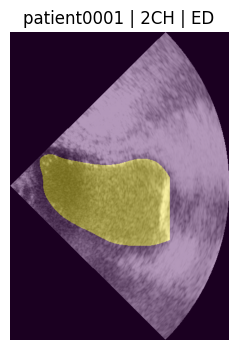

{'Dataset': 'CAMUS',
 'EF': 0.48954613224229393,
 'EDV_mL': 28841.0,
 'ESV_mL': 14722.0,
 'SV_mL': 14119.0,
 'CO_L_min': 1694.28,
 'EF_source': 'CAMUS_geometry'}

In [111]:
final_cardiac_output(camus_patients[0])

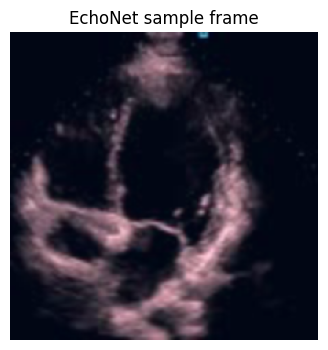

{'Dataset': 'ECHONET',
 'EF': 68.4995346069336,
 'EDV_mL': None,
 'ESV_mL': None,
 'SV_mL': None,
 'CO_L_min': None,
 'EF_source': 'ML_only'}

In [112]:
final_cardiac_output(test_video)